# Analisis de Prueba A/B 
Curso de DA - Sprint 9

## INTRODUCCION

### Objetivo

Priorizar hipótesis formuladas, lanzar un test A/B y analizar los resultados con el objetivo de  aumentar los ingresos. 



### Descripcion de los datos

<b> hypotheses_us.csv: </b> 

    Hypotheses: breves descripciones de las hipótesis 
    Reach: alcance del usuario, en una escala del uno a diez
    Impact: impacto en los usuarios, en una escala del uno al diez
    Confidence: confianza en la hipótesis, en una escala del uno al diez
    Effort: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. 
  

 <b> orders_us.csv: </b> 

    transactionId: identificador de pedido
    visitorId: identificador del usuario que realizó el pedido
    date: fecha del pedido
    revenue: ingresos del pedido
    group: el grupo del test A/B al que pertenece el usuario

<b> visits_us.csv: </b>

    date: la fecha
    group: grupo del test A/B
    visits: el número de visitas en la fecha especificada para el grupo de test A/B especificado

## PREPARACION DE LOS DATOS

### Importacion de librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

### Importacion de datasets

In [2]:
hipotesis = pd.read_csv('/datasets/hypotheses_us.csv', sep= ';')#, header= 0, names = ['hypothesis', 'reach','impact','confidence','effort'])

ordenes = pd.read_csv('/datasets/orders_us.csv')

visitas = pd.read_csv('/datasets/visits_us.csv')

### Hypotheses

In [3]:
hipotesis.columns = hipotesis.columns.str.lower()

print(hipotesis.head(9))
hipotesis.info()

                                          hypothesis  reach  impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   
5  Add a customer review page. This will increase...      3       2   
6  Show banners with current offers and sales on ...      5       3   
7  Add a subscription form to all the main pages....     10       7   
8  Launch a promotion that gives users discounts ...      1       9   

   confidence  effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  
5           2       3  
6           8       3  
7           8       5  
8           9       5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

Revisando el primer dataframe observamos que es un listado de ideas a probar para aumentar las ventas, se ordenaron los datos y se cambiaron las columnas a minusculas como pretrabajo.

### Orders

In [4]:
#print(ordenes.head())#Exploracion inicial de datos
#print()
#ordenes.info()

In [5]:
ordenes['date'] = pd.to_datetime(ordenes['date']) #Cambiar la columna de fecha a tipo datetime
#ordenes['date'] = ordenes['date'].map(lambda x: dt.datetime.strptime(x,'%d/%m/%Y'))
                                   

In [6]:
ordenes.duplicated().sum()#Revisar si los datos presentan filas duplicadas

0

In [7]:
#Revisar si hay usuarios que estan en ambos grupos y hacer un df con sus Id's 

repetidos = ordenes.groupby('visitorId', as_index = False)['group'].nunique().sort_values(by= 'group',ascending=False) 
repetidos_1 = repetidos[repetidos['group']> 1]['visitorId']
#print(repetidos_1)
print(repetidos_1.shape)#Se habian encontrado 58 usuarios con grupos repetidos

(58,)


In [8]:
#Se filtran las transacciones que contienen usuarios repetidos y son del grupo b para eliminarlos
filtro_1 = ordenes.query("visitorId in @repetidos_1 and group == 'B'") 
#print(filtro_1)

ordenes = ordenes.drop(filtro_1.index)

In [9]:
print(ordenes.groupby('group')['visitorId'].nunique())# Asi quedarian al final los grupos a y b

group
A    503
B    528
Name: visitorId, dtype: int64


In [10]:
print(ordenes.head())
print()
ordenes.info()

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B
2     2961555356  4069496402 2019-08-15     10.2     A
3     3797467345  1196621759 2019-08-15    155.1     B
4     2282983706  2322279887 2019-08-15     40.5     B

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1105 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1105 non-null   int64         
 1   visitorId      1105 non-null   int64         
 2   date           1105 non-null   datetime64[ns]
 3   revenue        1105 non-null   float64       
 4   group          1105 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 51.8+ KB


Se hizo una exploracion inicial de los datos del df de ordenes, no habia datos duplicados, se cambiaron los tipos de datos de dos columnas para optimizar el uso de memoria, Tambien se encontro que la prueba consta de dos categorias (A y B) y el tamaño de estas habia un total de 586 usuarios en el grupo B y 503 en el grupo A, al revisar los datos mas a detalle me percate de que habia usuarios con registros en los dos grupos por lo que opte en borrar todas las filas de transacciones registradas del grupo B y usuarios con registros en ambos grupos, para que esos usuarios se pasaran completamente al grupo A que es el que menos registros tenia en comparacion con el otro.


### Visits

In [11]:
#visitas.info()
#print()
#print(visitas.head())

In [12]:
visitas['date'] = pd.to_datetime(visitas['date']) #Cambiar la columna de fecha a tipo datetime


In [13]:
ordenes.duplicated().sum()#Revisar si los datos presentan filas duplicadas

0

In [14]:
visitas.info()
print()
print(visitas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB

        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756


Se hizo una revision inicial de los datos, se cambio los tipos de datos de la columna date y group a datetime y categorias para optimizar espacio y se reviso que no hubiera filas duplicadas.

## PRIORIZAR HIPOTESIS

In [15]:
print(hipotesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')


### ICE

In [16]:
hipotesis['ICE'] = (hipotesis['impact'] * hipotesis['confidence'] / hipotesis['effort']).round(2)
print(hipotesis.sort_values('ICE', ascending = False))

                                          hypothesis  reach  impact  \
8  Launch a promotion that gives users discounts ...      1       9   
0  Add two new channels for attracting traffic. T...      3      10   
7  Add a subscription form to all the main pages....     10       7   
6  Show banners with current offers and sales on ...      5       3   
2  Add product recommendation blocks to the store...      8       3   
1  Launch your own delivery service. This will sh...      2       5   
5  Add a customer review page. This will increase...      3       2   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   confidence  effort    ICE  
8           9       5  16.20  
0           8       6  13.33  
7           8       5  11.20  
6           8       3   8.00  
2           7       3   7.00  
1           4      10   2.00  
5           2       3   1.33  
3           3       8   1.12  
4         

### RICE

In [17]:
hipotesis['RICE'] = (hipotesis['impact'] * hipotesis['confidence'] * hipotesis['reach'] / hipotesis['effort']).round(2)
print(hipotesis.sort_values(by= 'RICE', ascending = False))

                                          hypothesis  reach  impact  \
7  Add a subscription form to all the main pages....     10       7   
2  Add product recommendation blocks to the store...      8       3   
0  Add two new channels for attracting traffic. T...      3      10   
6  Show banners with current offers and sales on ...      5       3   
8  Launch a promotion that gives users discounts ...      1       9   
3  Change the category structure. This will incre...      8       3   
1  Launch your own delivery service. This will sh...      2       5   
5  Add a customer review page. This will increase...      3       2   
4  Change the background color on the main page. ...      3       1   

   confidence  effort    ICE   RICE  
7           8       5  11.20  112.0  
2           7       3   7.00   56.0  
0           8       6  13.33   40.0  
6           8       3   8.00   40.0  
8           9       5  16.20   16.2  
3           3       8   1.12    9.0  
1           4      10  

Aplicando los metodos ICE y RICE observamos que ambos conciden en que las hipotesis 3,1,5 y 4 son las menos prioritarias, sin embargo observamos un cambio de posicion en las primeras 5 donde la hipotesis 8 que era el primer lugar en ICE paso a ser la quinta cuando tomamos en cuenta el alcance que tendra esta estrategia, ya que al parecer es poco e hipotesis como la 7 y la 2 que eran la tercera y la 5ta en ICE pasaron a los primeros lugares en RICE ya que el alcance que tienen es mayor  por lo que impactaran a un mayor grupo de la poblacion total lo que hace que los beneficios de estas estrategias sean mas generalizados aunque impacten en menor escala de forma individual.

## ANALISIS DE TEST A/B

### Ingreso acumulado por grupo

In [18]:
date_group= ordenes[['date','group']].drop_duplicates()
print(date_group)

           date group
0    2019-08-15     B
2    2019-08-15     A
45   2019-08-16     A
47   2019-08-16     B
55   2019-08-01     A
...         ...   ...
1068 2019-08-12     A
1114 2019-08-13     B
1116 2019-08-13     A
1149 2019-08-14     B
1150 2019-08-14     A

[62 rows x 2 columns]


In [ ]:
#crear variable orders_agg con los datos de transacciones acumulados por dia
orders_agg = date_group.apply(lambda x: ordenes[np.logical_and(ordenes['date'] <= x['date'], ordenes['group'] == x['group'])].agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique','revenue':'sum'}), axis=1).sort_values(by=['date','group'])

In [20]:
#crear variable visitor_agg con los datos de visitas acumuladas por dia
visitor_agg = date_group.apply(lambda x: visitas[np.logical_and(visitas['date'] <= x['date'], visitas['group'] == x['group'])].agg({'date':'max', 'group':'max','visits':'sum'}), axis=1).sort_values(by=['date','group'])

In [21]:
#Unir ambas tablas de valores acumulados para consolidar la informacion
data_agg= orders_agg.merge(visitor_agg, on=['date','group'])
data_agg.columns = ['date','group','orders','buyers','revenue','visits']
data_agg.columns

Index(['date', 'group', 'orders', 'buyers', 'revenue', 'visits'], dtype='object')

In [22]:
#Extraer un slice con la informacion de los ingresos acumulados por grupo
revenueA_acum = data_agg[data_agg['group']== 'A'][['date','orders','revenue']]
revenueB_acum = data_agg[data_agg['group']== 'B'][['date','orders','revenue']]

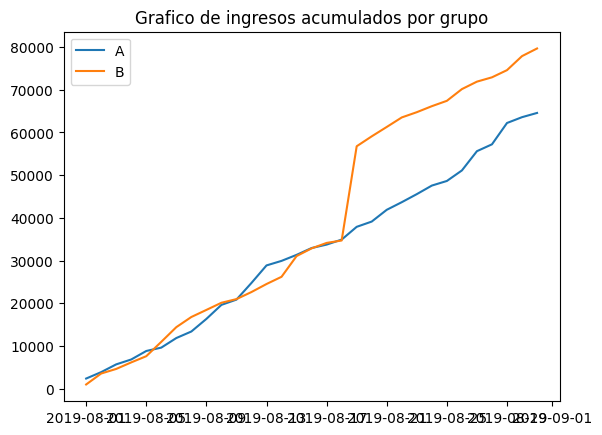

In [23]:
#Graficar los slices que creamos para comparar los ingresos acumulados por grupos
plt.plot(revenueA_acum['date'], revenueA_acum['revenue'], label= 'A')
plt.plot(revenueB_acum['date'], revenueB_acum['revenue'], label= 'B')
plt.title('Grafico de ingresos acumulados por grupo')
plt.legend()

Podemos observar en la grafica que hasta cierto punto las graficas estaban con un crecimiento muy similar y de repente la grafica del grupo B presento un crecimiento muy grande en una sola fecha y luego continuo con su crecimiento habitual diario. Este crecimiento puede deberse a una compra muy grande, lo identificaremos cuando hagamos el analisis de datos atipicos.

### Tamaño de pedido promedio acumulado por grupo

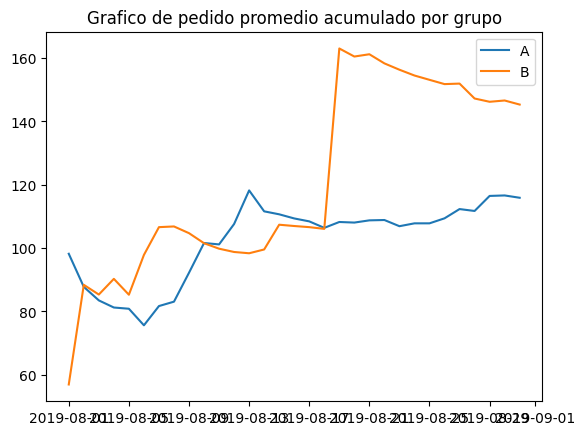

In [24]:
#Imprimir un grafico para conparar el tamaño medio de los pedidos en los dos grupos acumulado
plt.plot(revenueA_acum['date'], revenueA_acum['revenue'] / revenueA_acum['orders'], label='A')

plt.plot(revenueB_acum['date'], revenueB_acum['revenue'] / revenueB_acum['orders'], label='B')
plt.title('Grafico de pedido promedio acumulado por grupo')
plt.legend()

En esta grafica tambien podemos observar el pico en el mismo sitio del grupo B que en la grafica anterior y luego una caida mantenisda en el tamaño promedio de las compras, por lo que confirmamos que se debe a uno o mas condiciones anormales en ese dia.

### Diferencia relativa en el tamaño de pedido promedio acumulado

In [25]:
#Se calcula y grafica la diferencia relativa acumulada en el tamaño promedio de la compra
diff_rel = revenueA_acum.merge(revenueB_acum, on='date', suffixes=['A','B'])

ord_promA=diff_rel['revenueB'] / diff_rel['ordersB']

ord_promB=diff_rel['revenueA'] / diff_rel['ordersA']

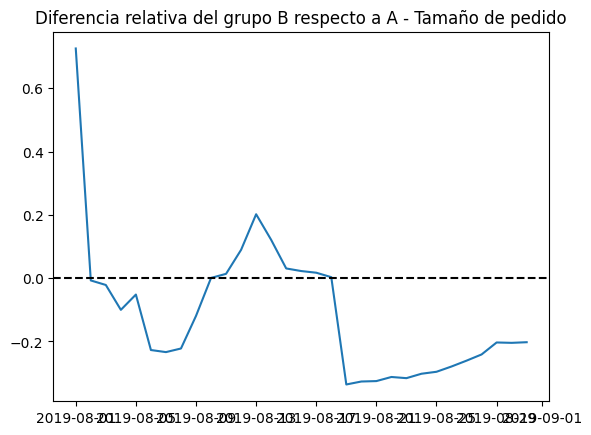

In [26]:
plt.plot(diff_rel['date'],(ord_promB / ord_promA) -1 )
plt.title('Diferencia relativa del grupo B respecto a A - Tamaño de pedido')
plt.axhline(y=0, color='black', linestyle='--')

En esta grafica observamos el comportamiento del tamaño promedio de las compras del grupo B respecto al grupo A, podemos ver que el grafico comienza con una caida mantenida hasta llegar a -20%, se recupera hasta alcanzar 20% de ganancia y vuelve a caer por debajo del -20% y comienza un crecimiento lento desde ahi.

### Tasa de conversión de cada grupo

In [27]:
#Se calcula la conversion entre las visitas a la pagina y las compras realizadas
data_agg['conversion'] = data_agg['orders'] / data_agg['visits']

group_A = data_agg[data_agg['group']== 'A']

group_B = data_agg[data_agg['group']== 'B']

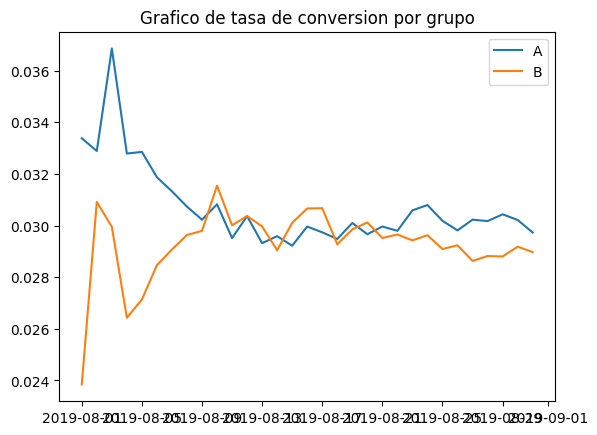

In [28]:
plt.plot(group_A['date'], group_A['conversion'], label= 'A')

plt.plot(group_B['date'], group_B['conversion'], label= 'B')
plt.title('Grafico de tasa de conversion por grupo')
plt.legend()

Observamos en la grafica que la conversion del grupo A comenzo alta, llegando casi al 0.4 de conversion pero despues cayo hasta el .3 y se mantiene oscilando entre el .3 y .32 ; el 
grupo B por su parte comenzo en .30, tuvo una caida en los primeros dias y despues crecio hasta rondar el mismo rango que el grupo A.

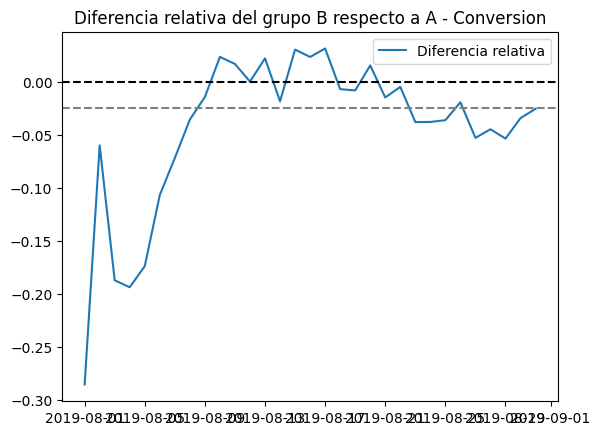

In [29]:
diff_rela = group_A.merge(group_B, on=['date'], suffixes=['A','B'])
diff_rela.columns
plt.plot(diff_rela['date'] , diff_rela['conversionB'] / diff_rela['conversionA']-1, label='Diferencia relativa')
plt.legend()
plt.title('Diferencia relativa del grupo B respecto a A - Conversion')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= -0.025, color='gray', linestyle='--')

En esta ultima grafica observamos el comportamiento de la conversion del grupo B respecto al grupo A, observamos que empezo muy rezagado, despues mejoro y comenzo ganar respecto al grupo B, luego volvio a caer y actualmente se encuentra en 0.025 y con tendencia creciente.

### Gráfico de dispersión del número de pedidos por usuario.

In [30]:
#Crear un df con solamente los datos de usuarios y ordenes para analizar los pedidos por usuario
orders_per_usr = (
    ordenes.drop(['group','revenue','date'], axis=1)
    .groupby('visitorId', as_index = False)
    .agg({'transactionId': pd.Series.nunique})
)

orders_per_usr.columns = ['visitorId','orders']
print(orders_per_usr.sort_values(by='orders', ascending = False).head(10))

       visitorId  orders
1023  4256040402       7
487   2038680547       5
591   2458001652       5
44     199603092       4
569   2378935119       4
55     237748145       4
504   2108163459       3
667   2742574263       3
959   3967698036       3
726   2988190573       3


(array([983.,  33.,   0.,   9.,   0.,   3.,   2.,   0.,   0.,   1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

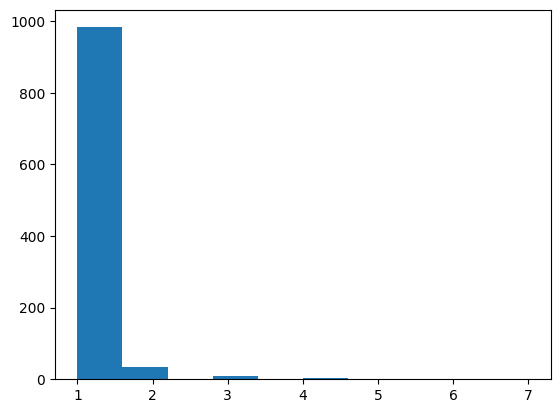

In [31]:
plt.hist(orders_per_usr['orders'])

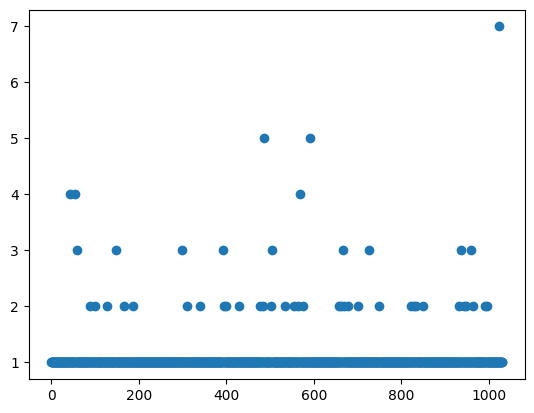

In [32]:
x_values = pd.Series(range(0,len(orders_per_usr)))

plt.scatter(x_values, orders_per_usr['orders'])

### Percentiles 95 y 99 para el número de pedidos por usuario

In [33]:
print(np.percentile(orders_per_usr['orders'], [90 , 95, 99]))

[1. 1. 3.]


Podemos observar en el df 'orders_per_usr' y en las graficas que en su mayoria los pedidos por usuario es de 1, el maximo de pedidos por usuario es 7 pedidos de un usuario y 5 pedidos de 2 usuarios, habra que evaluar si estos usuarios afectan la confiabilidad del analisis.

Ademas al calcular los percentiles 95 y 99 nos damos cuenta de que el 95% de los pedidos siguen siendo de 1 por usuario y solamente cambia a 3 en el 99%. Por lo tanto se consideraran pedidos anomalos los que sean mayores que 3 por usuario.

### Dispersión de los precios de los pedidos

In [34]:
print(ordenes['revenue'].sort_values(ascending=False).head(10))

425     19920.4
1196     3120.1
858      1450.2
1136     1425.8
744      1335.6
662      1220.2
743      1050.0
1103     1025.8
1099     1015.9
949       930.0
Name: revenue, dtype: float64


(array([863., 146.,  48.,  20.,   9.,   7.,   5.,   1.,   2.,   2.]),
 array([   0.,  150.,  300.,  450.,  600.,  750.,  900., 1050., 1200.,
        1350., 1500.]),
 <BarContainer object of 10 artists>)

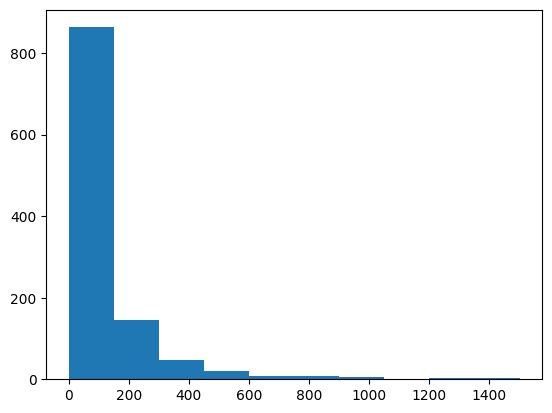

In [35]:
#Imprimir histograma para ver en que rango de encuentra la ganancia por compra
plt.hist(ordenes['revenue'], range =(0 , 1500))

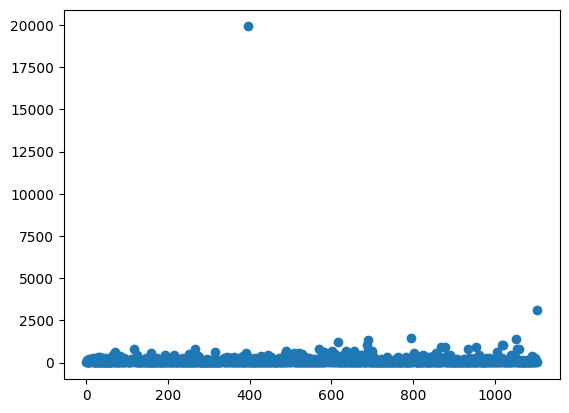

In [36]:
x_val = pd.Series(range(0, len(ordenes)))

plt.scatter(x_val, ordenes['revenue'])

### Percentiles 95 y 99 de los precios de los pedidos

In [37]:
print(np.percentile(ordenes['revenue'],[90,95,99]))

[280.8   425.56  897.884]


Podemos observar en el la colimna 'revenue' y en las graficas que en su mayoria los pedidos menos de 200,se encontro que el monto maximo de compra fue de u pedido de 19000+, algo totalmente alejado del promedio, por lo que este resultado es claramente una compra anormal.

Ademas al calcular los percentiles 95 y 99 nos damos cuenta de que el 95% de los pedidos son de  400 y el 99 alcanzan un monto de poco menos de 900 por lo tanto se consideraran pedidos anomalos los que sean mayores que esta cantidad.

In [38]:
ordenes.columns
visitas.columns

Index(['date', 'group', 'visits'], dtype='object')

### Significancia estadística de la diferencia en la conversión entre los grupos (Datos en bruto)

In [39]:
order_per_usrA = ordenes[ordenes['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
order_per_usrA.columns=['visitorId','orders']

order_per_usrB = ordenes[ordenes['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
order_per_usrB.columns=['visitorId','orders']

sampleA= pd.concat([
    order_per_usrA['orders'], 
    pd.Series(0,index= np.arange(
        visitas[visitas['group']=='A']['visits'].sum() - len(order_per_usrA['orders'])), name='orders')], axis=0)

sampleB= pd.concat([
    order_per_usrB['orders'] , 
    pd.Series(0,index= np.arange(
        visitas[visitas['group']=='B']['visits'].sum() - len(order_per_usrB['orders'])), name='orders')], axis=0)

In [40]:
print('Valor P:','{0:.3f}'.format(stats.mannwhitneyu(sampleA , sampleB)[1]))

print('Diferencia relativa:','{0:.3f}'.format(sampleB.mean() / sampleA.mean() -1))

Valor P: 0.534
Diferencia relativa: -0.026


Observamos en el resultado anterior que el valor p es mayor que nuestro valor alpha de 0.05, por lo que no hay evidencia de un cambio significativo en ambos grupos en cuando a la conversion.
Observamos en la segunda fila que la perdida relativa del grupo B es del 2%.

### Significancia estadística de la diferencia en el tamaño promedio de pedido (Datos en bruto)

In [41]:
group_A = ordenes[ordenes['group']=='A']
group_B = ordenes[ordenes['group']=='B']

In [42]:
print('Valor P:','{0:.3f}'.format(stats.mannwhitneyu(group_A['revenue'], group_B['revenue'])[1]))

print('Diferencia relativa:','{0:.3f}'.format(group_B['revenue'].mean() / group_A['revenue'].mean() -1))

Valor P: 0.888
Diferencia relativa: 0.254


Observamos en el resultado anterior que el valor p es mayor que nuestro valor alpha de 0.05, por lo que no hay evidencia de un cambio significativo en ambos grupos en cuando al tamaño promedio del pedido.

En la fila 2 se observa una ganancia relativa del 25% en el tamaño promedio de la compra del grupo B, esto puede deberse al pedido anormal que detectamos anteriormente.

### Significancia estadística de la diferencia en la conversión entre los grupos (Datos filtrados)

In [43]:
#Separar y enlistar los usuarios que tienen un comportamiento anormal.
usr_many_ord = orders_per_usr[orders_per_usr['orders']> 3 ]['visitorId']

usr_exp_ord = ordenes[ordenes['revenue']> 900]['visitorId']

abnormal_usr = pd.concat([usr_many_ord,usr_exp_ord],axis=0).drop_duplicates()

In [44]:
#Separo los usuarios con anomalias y creo un series con la cantidad de pedidos totales por usuario
sample_A1 = order_per_usrA[~order_per_usrA['visitorId'].isin(abnormal_usr)]['orders']
sample_B1 = order_per_usrB[~order_per_usrB['visitorId'].isin(abnormal_usr)]['orders']
#Hago un objeto series para combinar con el series que se creo anteriormente para considerar a los usuarios que no hicieron pedidos
sample_A2 = pd.Series(0, index= np.arange(visitas[visitas['group']=='A']['visits'].sum() - len(order_per_usrA['orders'])), name='orders')
sample_B2 = pd.Series(0, index= np.arange(visitas[visitas['group']=='B']['visits'].sum() - len(order_per_usrB['orders'])), name='orders')

In [45]:
sampleAfilter = pd.concat([sample_A1 , sample_A2], axis=0 )
sampleBfilter = pd.concat([sample_B1 , sample_B2], axis=0 )

In [46]:

print('Valor P:','{0:.3f}'.format(stats.mannwhitneyu(sampleAfilter , sampleBfilter)[1]))

print('Diferencia relativa:','{0:.3f}'.format( sampleBfilter.mean() /sampleAfilter.mean() -1))

Valor P: 0.361
Diferencia relativa: 0.034


Observamos en el resultado anterior que el valor p es mayor que nuestro valor alpha de 0.05, por lo que no hay evidencia de un cambio significativo en ambos grupos en cuando a la conversion.

Este es el mismo resultado que se obtuvo antes de filtrar los datos para eliminar los datos anormales.

Observamos en la segunda fila que la perdida relativa del grupo B es del 3.4%. Aqui se observa una diferencia del 1.4% repecto al resultado que obtuvimos antes de filtrar el df.

### Significancia estadística de la diferencia en el tamaño promedio de pedido (Datos filtrados)

In [47]:
#Filtrar los usuarios con compras inusuales del dataframe
ordenes_filter = ordenes[~ordenes['visitorId'].isin(abnormal_usr)]

In [48]:
#Separar los grupos A y B para la prueba estadistica
groupA_1 = ordenes_filter[ordenes_filter['group']=='A']['revenue']

groupB_1 = ordenes_filter[ordenes_filter['group']=='B']['revenue']

In [49]:
print('Valor P:','{0:.3f}'.format(stats.mannwhitneyu(groupA_1 , groupB_1)[1]))

print('Diferencia relativa:','{0:.3f}'.format(groupB_1.mean() / groupA_1.mean() -1))

Valor P: 0.885
Diferencia relativa: -0.029


Observamos en el resultado anterior que el valor p es mayor que nuestro valor alpha de 0.05, por lo que no hay evidencia de un cambio significativo en ambos grupos en cuando al tamaño promedio del pedido.

Este esta es la misma conclusion que habiamos obtenido antes de filtrar los datos, pero podemos ver que el valor p se reduce una cantidad minima(.003)

En la fila 2 se observa  ahora una perdida relativa de casi el 3% en el tamaño del pedido, anterioormente se habia obtenido un resultado de 25% de ganancia en el analisis realizado antes de filtrar los valores anormales.

## CONCLUSION

Se priorizaron 9 hipotesis para aumentar las ventas, se aplicaron los metodos de ICE y RICE para evaluar con los criterios dados cuales eran las mejores opciones, llegando a los siguientes resultados de top 3:

    -La hipotesis 7: Alto impacto y confiabilidad, esfuerzo medio y un alcance de 10.
    "Add a subscription form to all the main pages. This will help you compile a mailing list"

    -La hipotesis 2: Bajo impacto, media alta confiabilidad y bajo esfuerzo, alcance del 80%.
    "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size"

    -La hipotesis 0: Bajo alcance, alto impacto y confiabilidad, esfuerzo medio.
    "Add two new channels for attracting traffic. This will bring 30% more users"

En este analisis tambien revisamos los datos resultantes de una prueba con los grupos A y B.

Se  graficaron, calcularon y compararon los datos de la conversion media por grupo y el tamaño promedio de los pedidos realizados, despues de este analisis se obtuvieron los siguientes resultados:

    - El grafico que muestra la diferencia relativa de tamaño promedio de pedido  nos indica que los resultados del grupo B son peores y no se recuperan, hasta el final indican una caida del 20% repecto al tamaño de pedido promedio del grupo A.
    
    -El grafico que muestra la diferencia relativa de conversion  nos indica que los resultados del grupo B oscilan mayormente sobre el 0, lo que indicaria que son similares a los del grupo B, sin embargo ya para el final de la prueba caen un -5% manteniendo despues tendencia positiva hasta el -2.5%, por lo que el resultado termina en perdida de conversion.
    
    -Los datos resultantes de las pruebas estadisticas con datos filtrados y datos en bruto nos llevaron a la misma conclusion, no hay una diferencia significativa entre el tamaño promedio de pedido entre el grupo A y B.
    
    -Los datos resultantes de las pruebas estadisticas con datos filtrados y datos en bruto nos llevaron a la misma conclusion, no hay una diferencia significativa entre el tamaño promedio de pedido entre el grupo A y B. El grupo B tuvo una predida relativa de 3% respecto al grupo A en el tamaño promedio de pedido.
    
      -Los datos resultantes de las pruebas estadisticas con datos filtrados y datos en bruto nos llevaron a la misma conclusion, no hay una diferencia significativa entre la conversion del grupo A y B. El grupo B tuvo una predida relativa de 3% respecto al grupo A en la conversion.

## RECOMENDACIONES

<b> Hipotesis prioritarias</b>

Se recomiendan la Hipotesis 7 y 2 principalmente por su alto impacto y confiabilidad seguido de la hipotesis 2 que parece ser una tarea sencilla y que puede tener beneficios pequeños a corto plazo.

<b>Prueba A/B</b></b>

Basandonos en los resultados obtenidos de las pruebas estadisticas concluimos que la prueba no fue exitosa y debe darse por terminada.
Despues de analizar los resultados creemos que muy dificilmente el grupo B resulte mejor que el grupo A aunque se continue con la prueba mas tiempo.